---

# Machine Learning: Predictive Regression Modeling for Housing Prices  <a class="tocSkip">

&nbsp;

### By Nicholas Lucido <a class="tocSkip">


--- 

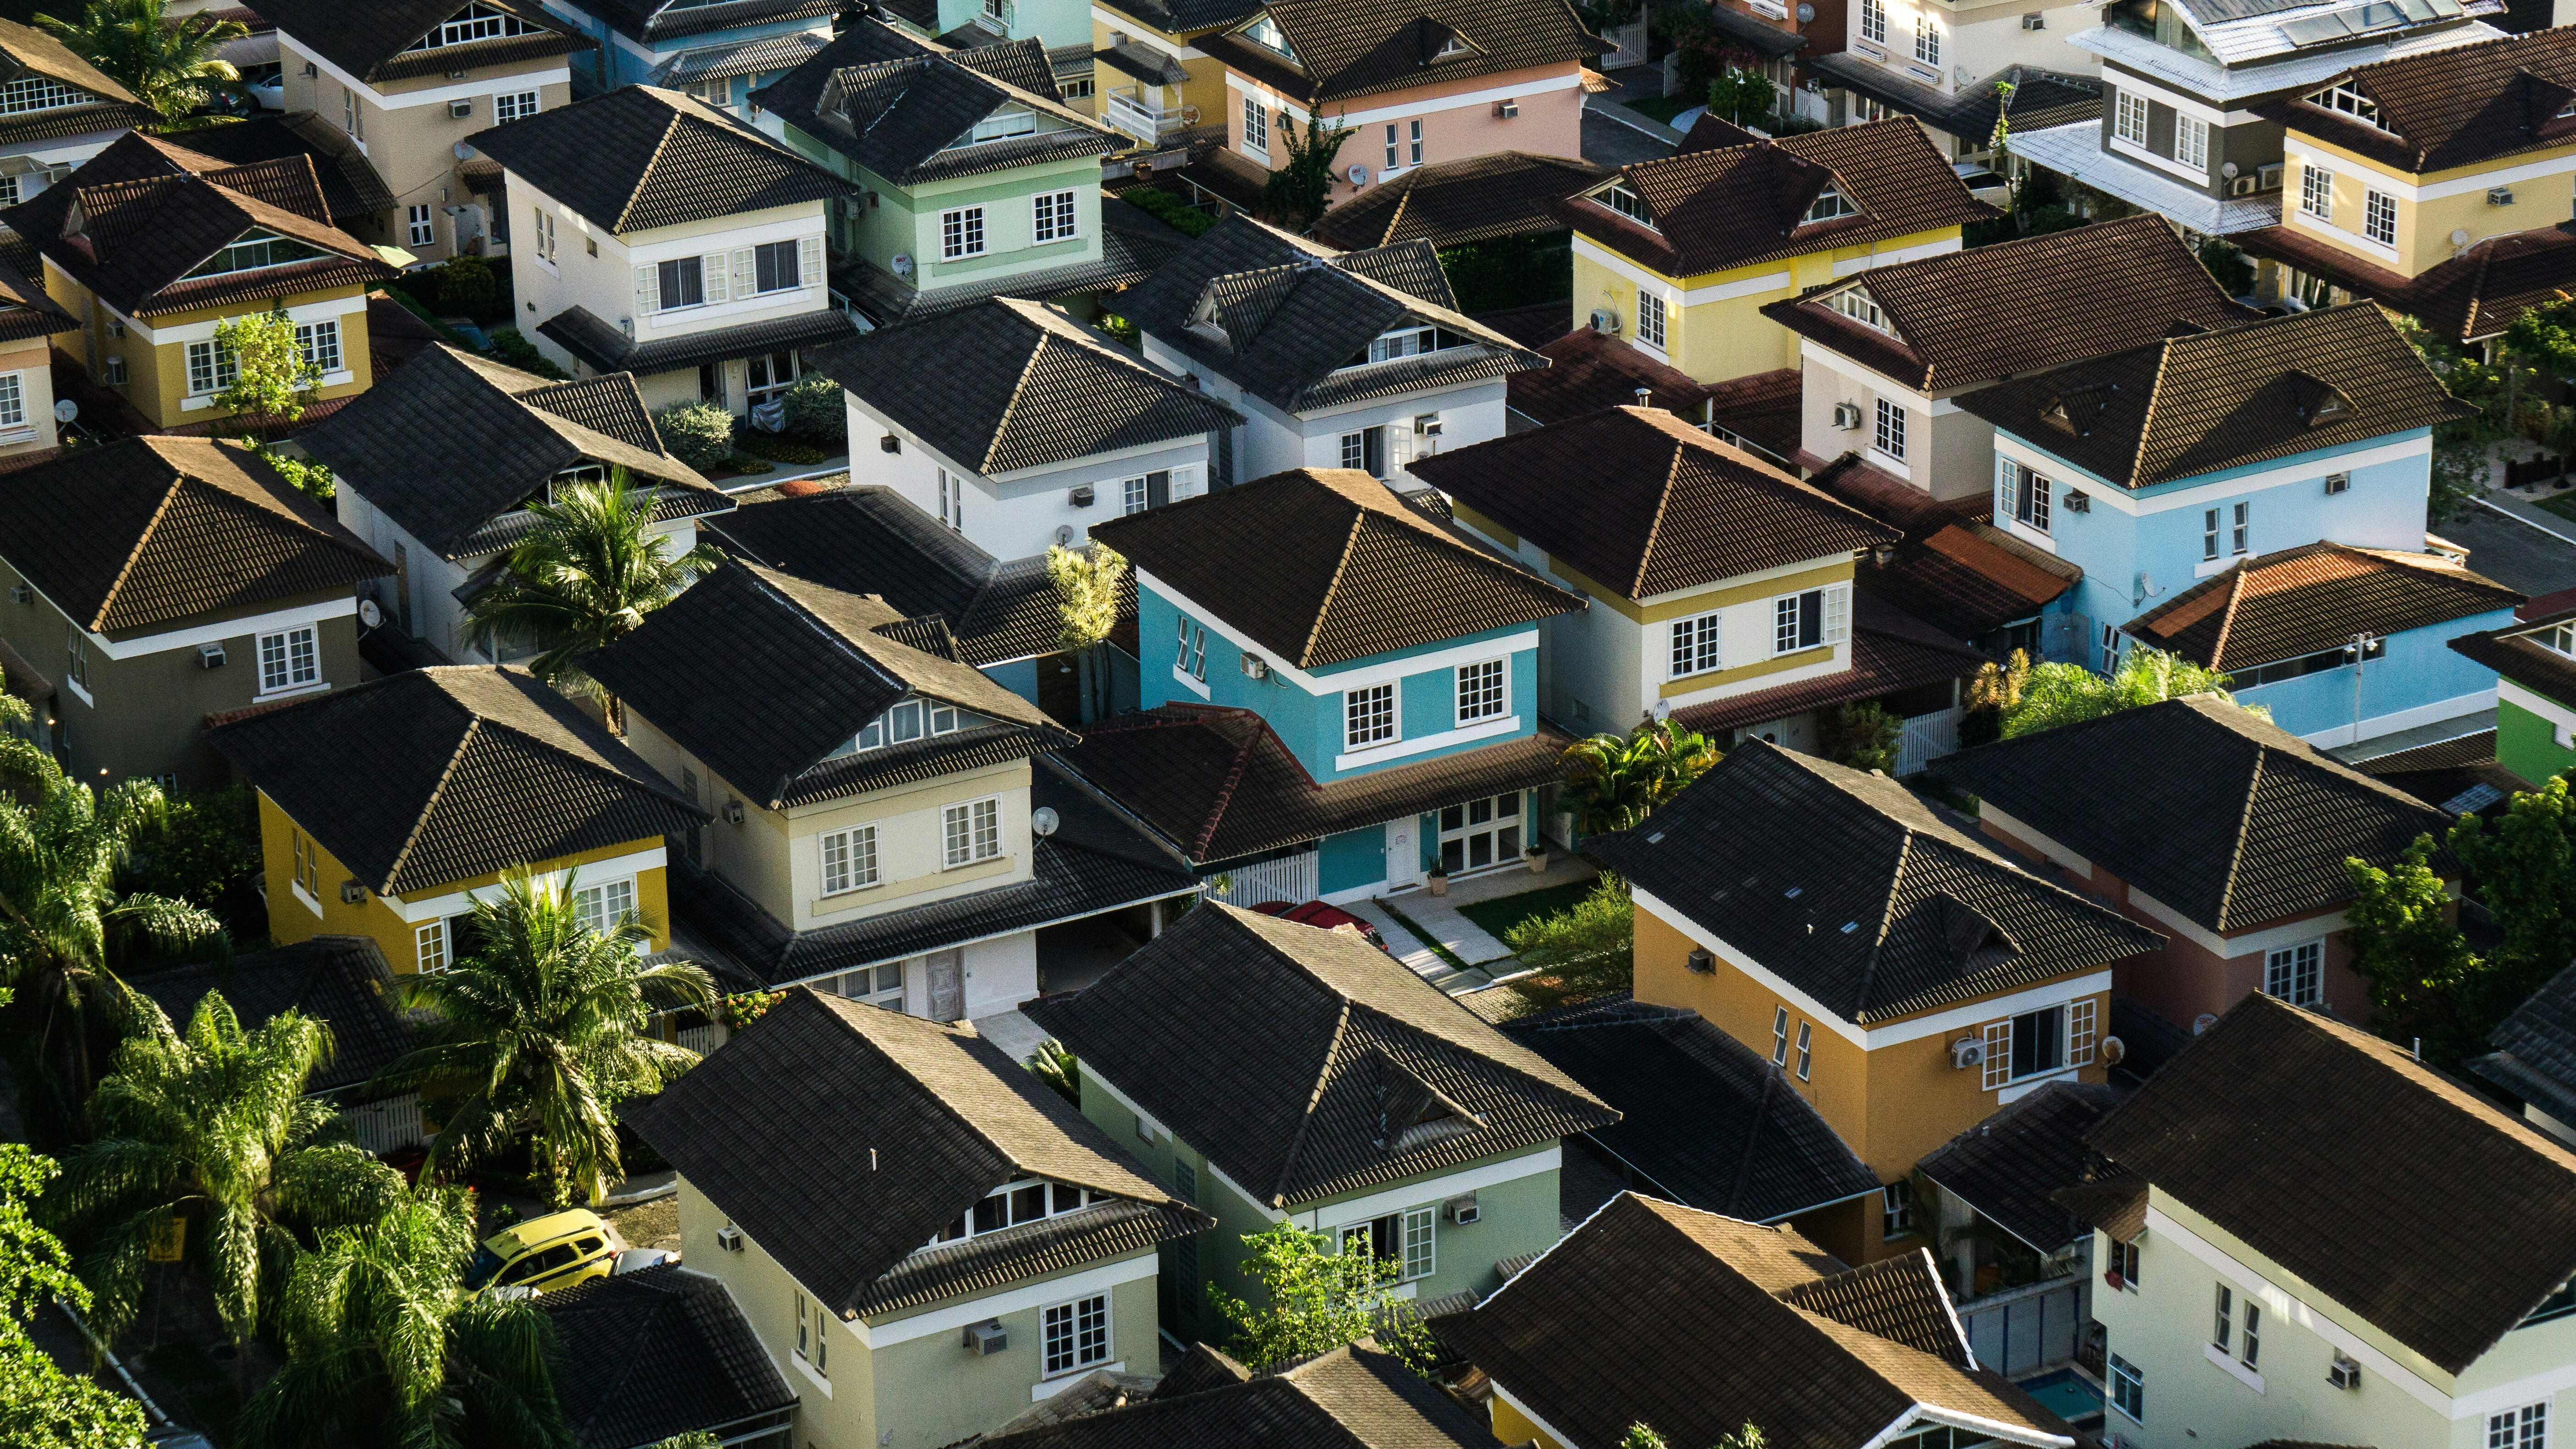

---

# Introduction:

Welcome to the <b>Machine Learning: Predictive Regression Modeling for Housing Prices</b> project! In today's real estate market, accurately determining the price of a property is crucial for both buyers and sellers. With the advent of machine learning techniques, predicting housing prices has become more precise and efficient than ever before.

In this project, we delve into a [housing dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data) containing various features such as area, number of bedrooms and bathrooms, presence of amenities like guest rooms, basements, hot water heating, and air conditioning, as well as proximity to main roads. Our objective is test various machine learning regression algorithms to determine which one generalizes to the data the most efficiently.    

--- 

## Objective: 

The primary goal of this project is to understand the dataset thoroughly, preprocess it if necessary, and then employ regression techniques to develop predictive models. We aim to evaluate the performance of these models using metrics such as R-squared (R2) and Root Mean Squared Error (RMSE) to ensure their effectiveness in capturing the variability in housing prices.
    
A potential challenge we anticipate in this project is dealing with strong multicollinearity among the features. Multicollinearity can inflate the variance of the regression coefficients, leading to inaccurate predictions, so we will remain mindful of this potential pitfall. 
    
To begin, we will explore the dataset by visualizaing the distributions of its features, identifying any outliers or values that may require preprocessing. Once the data has been validated and prepared, we will split it into training and testing sets to train our various regression models which include linear regression, decision trees, and ensemble methods like random forests.
    
To evaluate the performance of our models, we will use cross-validation techniques and compute relevant evaluation metrics such as R2 and RMSE. Additionally, we will compare the predicted prices with the actual prices to assess the accuracy and reliability of our models, and conclude with the model that has produced the best fit. 
    
Let's dive into the fascinating world of housing price prediction and unlock the potential of machine learning in real estate valuation!


--- 

# Import Data 

---

In [61]:
# Read in libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate
from scipy.stats import probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Read in data
housing_data = pd.read_csv("/Users/nicklucido/Documents/Jupyter Notebook/Python/Housing.csv")

housing_data.head()

price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished

--- 

# Data Validation 

---

We'll begin by verifying the accuracy of the data by examining the different types, checking for missing values, and gaining a better overall view of the data's various attributes.

In [62]:
# Data types in table 
housing_data.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [63]:
# Check for missing values 
missing_values_count = housing_data.isnull().sum()

missing_values_count[0:13]

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [64]:
# Check unique values
housing_data.apply(lambda col: col.unique())

price               [13300000, 12250000, 12215000, 11410000, 10850...
area                [7420, 8960, 9960, 7500, 8580, 16200, 8100, 57...
bedrooms                                           [4, 3, 5, 2, 6, 1]
bathrooms                                                [2, 4, 1, 3]
stories                                                  [3, 4, 2, 1]
mainroad                                                    [yes, no]
guestroom                                                   [no, yes]
basement                                                    [no, yes]
hotwaterheating                                             [no, yes]
airconditioning                                             [yes, no]
parking                                                  [2, 3, 0, 1]
prefarea                                                    [yes, no]
furnishingstatus             [furnished, semi-furnished, unfurnished]
dtype: object

In [65]:
# Rename columns 
housing_data = housing_data.rename(columns={'mainroad':'main_road', 'guestroom':'guest_room', 'hotwaterheating':'hot_water_heating', 
                                            'airconditioning':'air_conditioning', 'prefarea':'preferred_area', 'parking':'parking_spots', 
                                            'furnishingstatus':'furnishing_status'})
# Cleaned df 
df = housing_data

num_rows, num_columns = df.shape

print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

df.head()

Number of rows: 545, Number of columns: 13


price  area  bedrooms  bathrooms  stories main_road guest_room basement  \
0  13300000  7420         4          2        3       yes         no       no   
1  12250000  8960         4          4        4       yes         no       no   
2  12250000  9960         3          2        2       yes         no      yes   
3  12215000  7500         4          2        2       yes         no      yes   
4  11410000  7420         4          1        2       yes        yes      yes   

  hot_water_heating air_conditioning  parking_spots preferred_area  \
0                no              yes              2            yes   
1                no              yes              3             no   
2                no               no              2            yes   
3                no              yes              3            yes   
4                no              yes              2             no   

  furnishing_status  
0         furnished  
1         furnished  
2    semi-furnished  
3         furnished  
4         furnished

&nbsp;

With our data cleaned and better understood, we're now ready to explore and visualize its features for deeper insights.

--- 

# Exploratory Data Analysis  

---

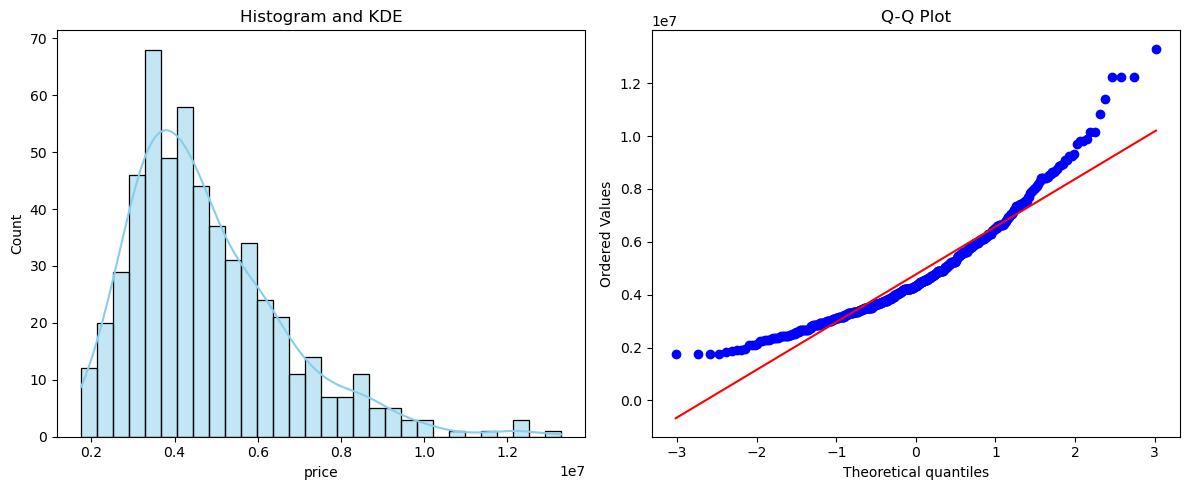

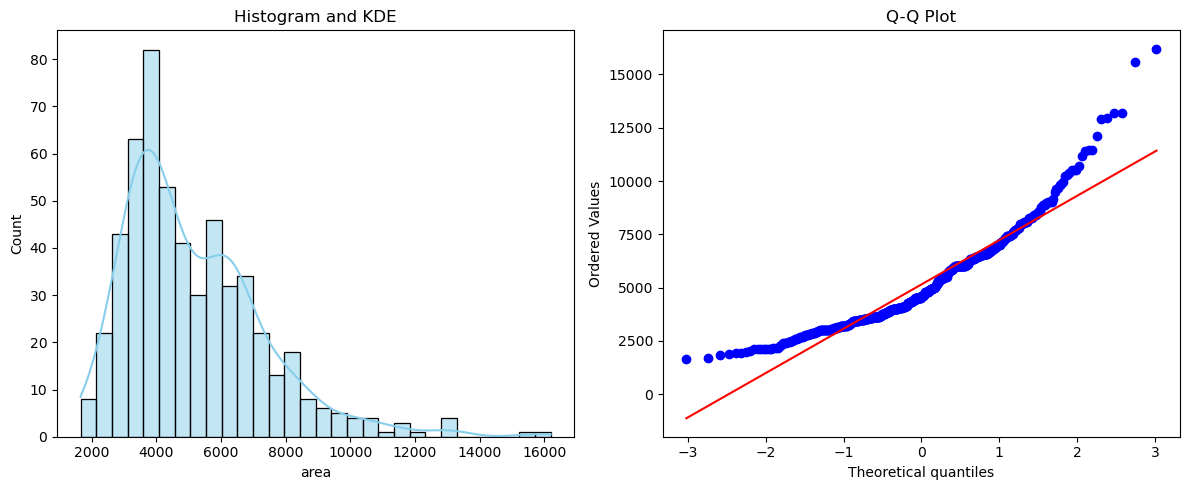

In [66]:
# Function to visualize distribution of numerical variables  
def visualize_distribution(df, numerical_column):
    mp.figure(figsize=(12, 5))
    mp.subplot(1, 2, 1)
    sns.histplot(df[numerical_column], kde=True, bins=30, color='skyblue')
    mp.title('Histogram and KDE')

    # Q-Q plot
    mp.subplot(1, 2, 2)
    probplot(df[numerical_column], plot=mp)
    mp.title('Q-Q Plot')

    mp.tight_layout()
    mp.show()

visualize_distribution(housing_data, 'price')
visualize_distribution(housing_data, 'area')


<b>Inference:</b> From both the histogram plot with KDE and the Q-Q plot of our 'price' and 'area' variables, it's evident that both exhibit a right skew.

---

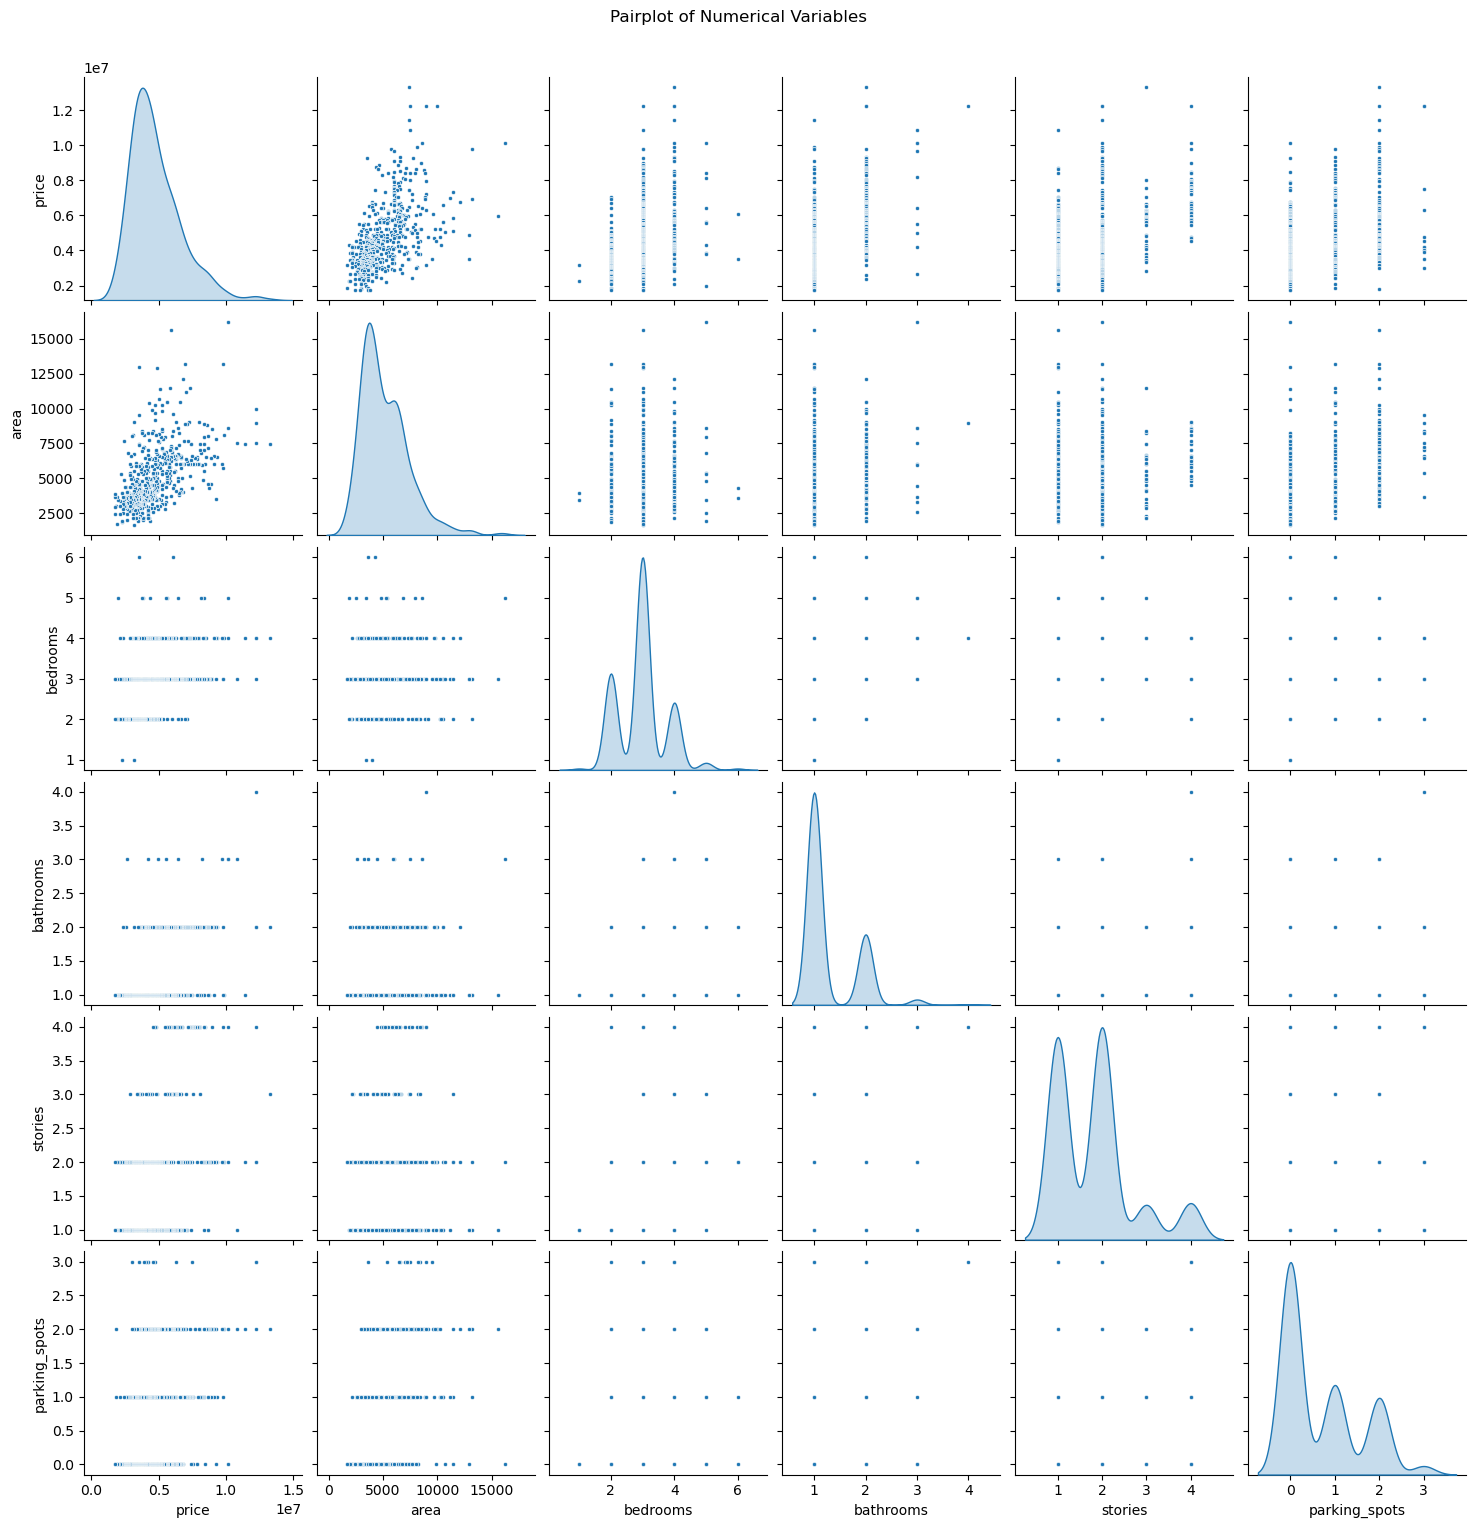

In [67]:
# Pairplot visualization of numerical variables 
sns.pairplot(df, markers='.', height=2.5, diag_kind='kde', diag_kws=dict(fill=True))

mp.suptitle("Pairplot of Numerical Variables", y=1.02)
mp.xlabel("X-axis label")
mp.ylabel("Y-axis label")

mp.show()

<b> Inference </b> The pairplot visualization suggests a strong linear correlation between the 'price' and 'area' variables. 

---

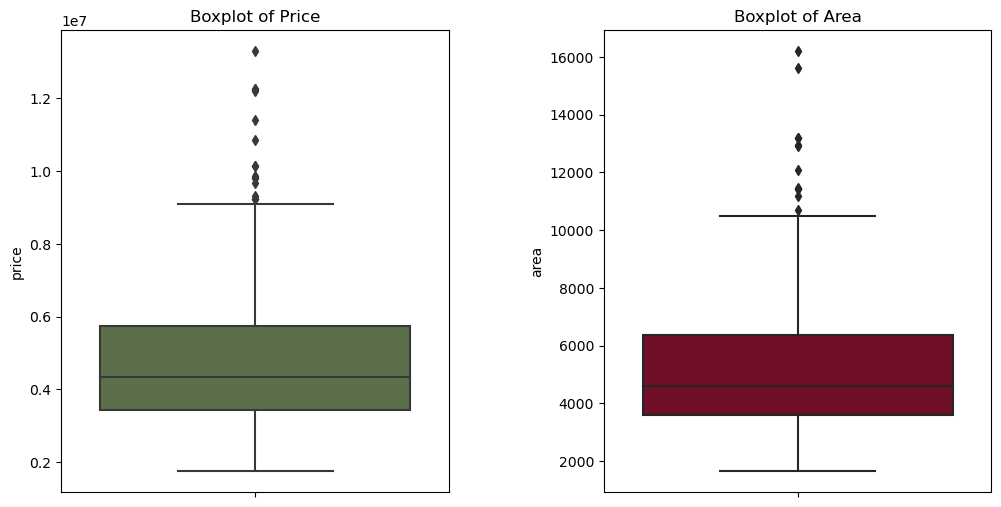

In [68]:
# Select variables 'price' and 'area' to observe distributions 
numerical_variables = ['price', 'area']
numerical_df = df[numerical_variables]

# Set up matplotlib
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.4)

colors = ['#5a7644', '#800020'] 

# Plot boxplots for 'price' and 'area'
for i, variable in enumerate(numerical_variables):
    sns.boxplot(data=numerical_df, y=variable, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Boxplot of {variable.capitalize()}')

mp.show()

<b>Inference:</b> Outliers are potentially present in both the 'price' and 'area' variables. Further investigation and preprocessing of the data will be conducted to address this issue.

---

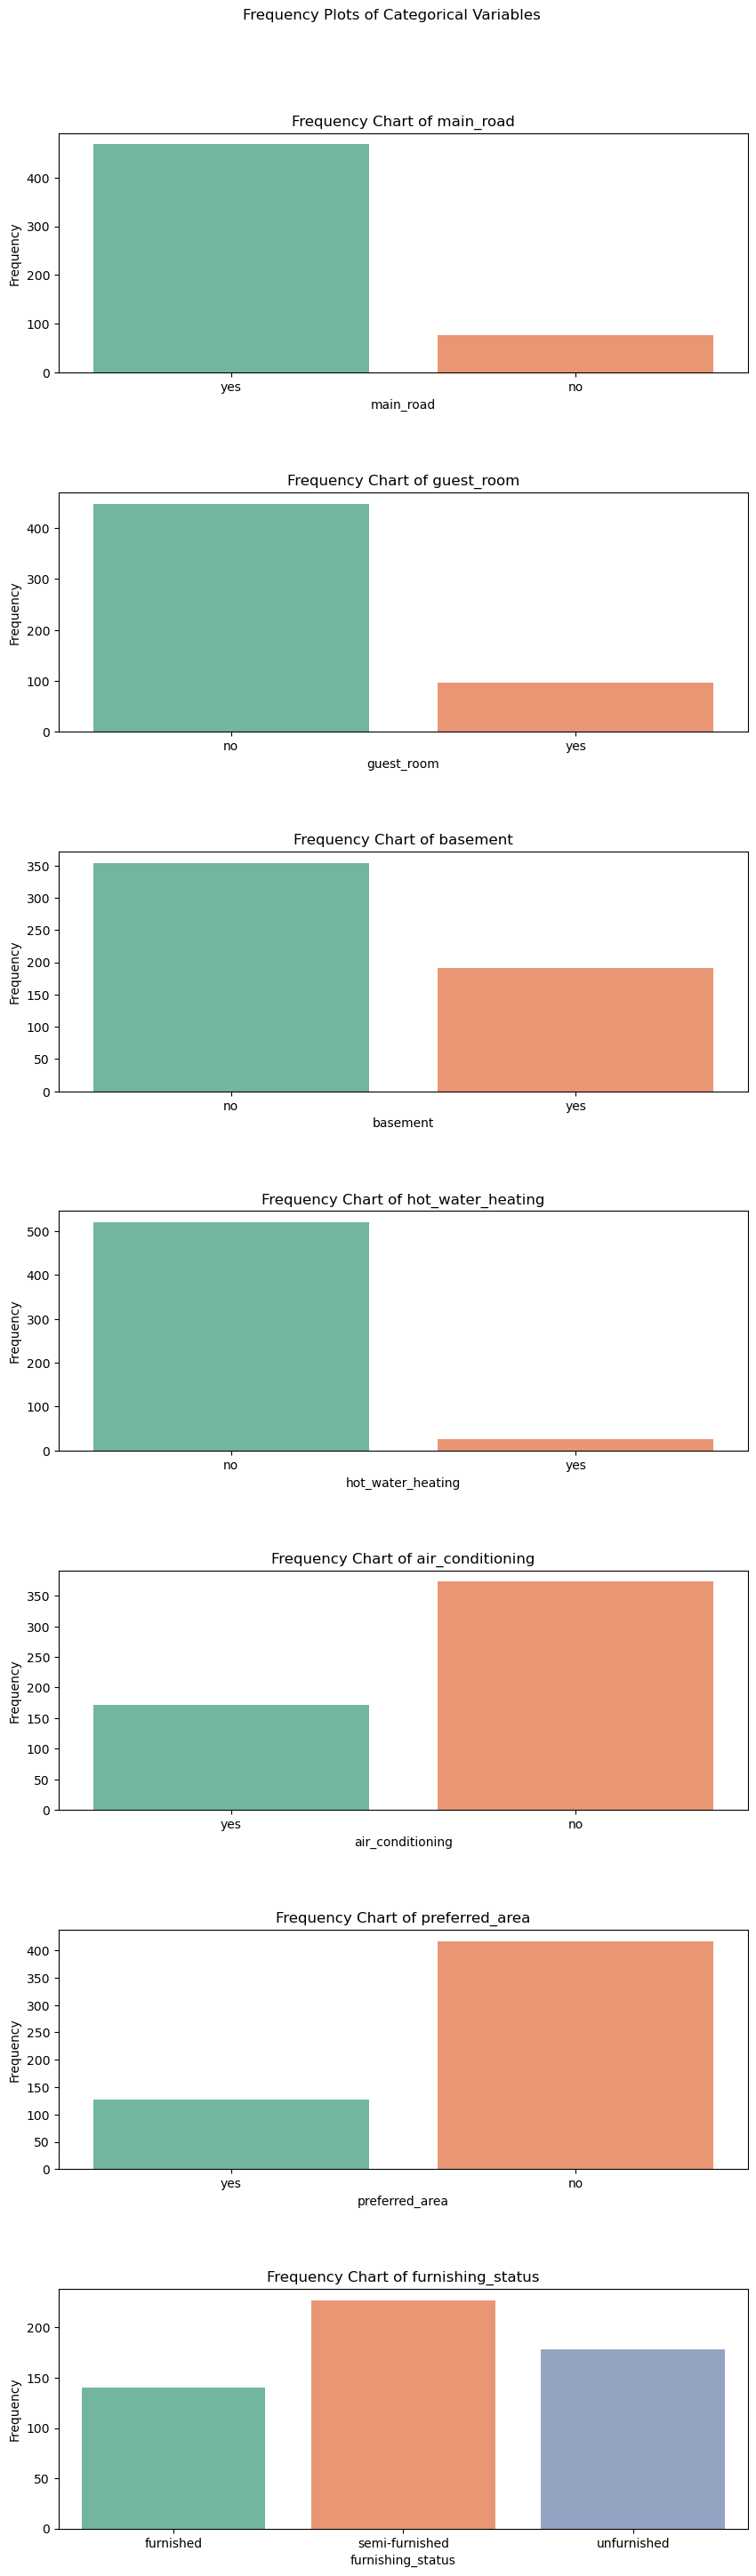

In [69]:
# Extract categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Set up matplotlib
fig, axes = mp.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, len(categorical_columns) * 5))
mp.subplots_adjust(hspace=0.5)

color_palette = sns.color_palette("Set2")

# Iterate over each categorical column to create frequency plots 
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axes[i], palette=color_palette)

    axes[i].set_title(f'Frequency Chart of {col}')  # Changed title
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

mp.suptitle("Frequency Plots of Categorical Variables", y=0.92)  # Changed title and adjusted y position

mp.show()

---

Let's observe the strength of association between both the categorical and numerical variables and identify potential multicollinearity by examining a correlation matrix of the dataset.

price                               1.000000
area                                0.535997
bathrooms                           0.517545
air_conditioning_yes                0.452954
stories                             0.420712
parking_spots                       0.384394
bedrooms                            0.366494
preferred_area_yes                  0.329777
main_road_yes                       0.296898
furnishing_status_unfurnished       0.280587
guest_room_yes                      0.255517
basement_yes                        0.187057
hot_water_heating_yes               0.093073
furnishing_status_semi-furnished    0.063656
Name: price, dtype: float64


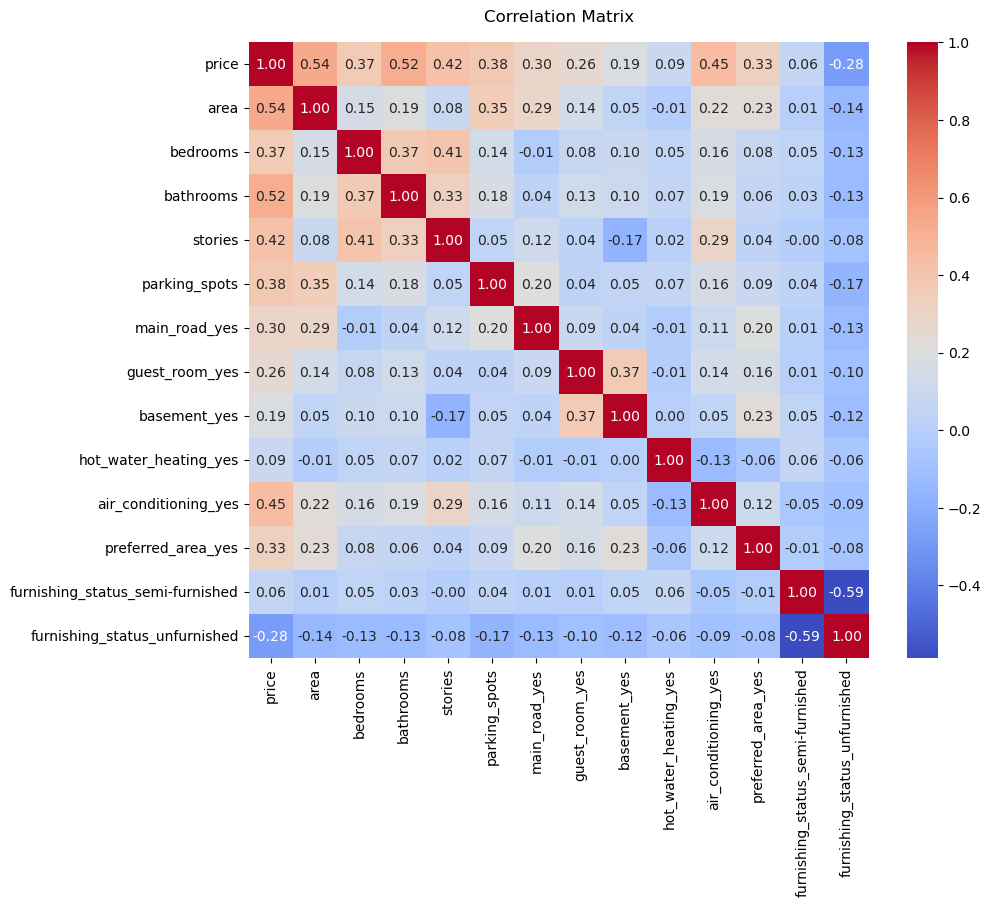

In [70]:
# Convert categorical variables to one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Compute correlation matrix
correlation_matrix = df_encoded.corr()

# Extract correlations with target variable set as 'price'
price_correlations = correlation_matrix['price'].abs().sort_values(ascending=False)

print(price_correlations)

# Create heatmap
mp.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
mp.title("Correlation Matrix", y=1.02)
mp.show()

The correlation matrix is symmetric, so we can observe just one triangle to assess the correlations effectively. Let's now plot the variables with the highest correlation, 'price' and 'area', to identify potential linear trends and pinpoint numerical features that may introduce multicollinearity.


---

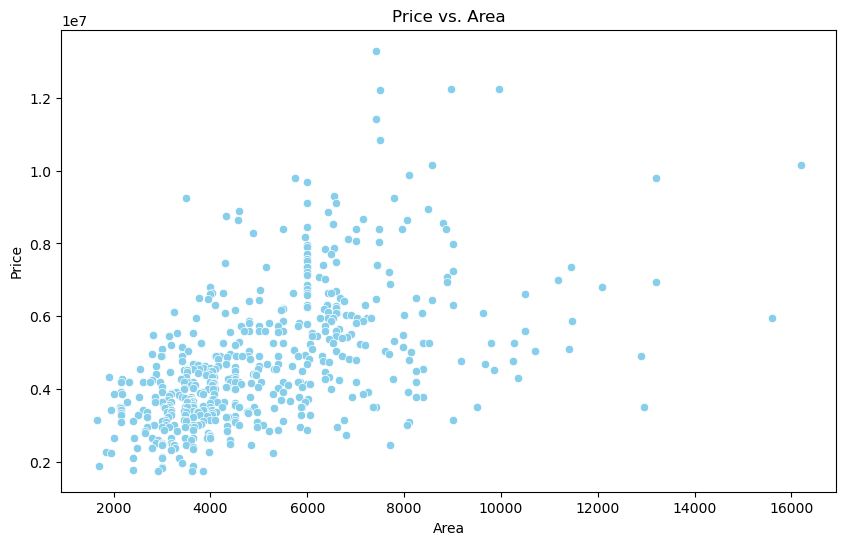

In [71]:
# Scatterplot between 'price' and 'area'
mp.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='price', data=housing_data, color='skyblue')
mp.title('Price vs. Area')
mp.xlabel('Area')
mp.ylabel('Price')
mp.show()

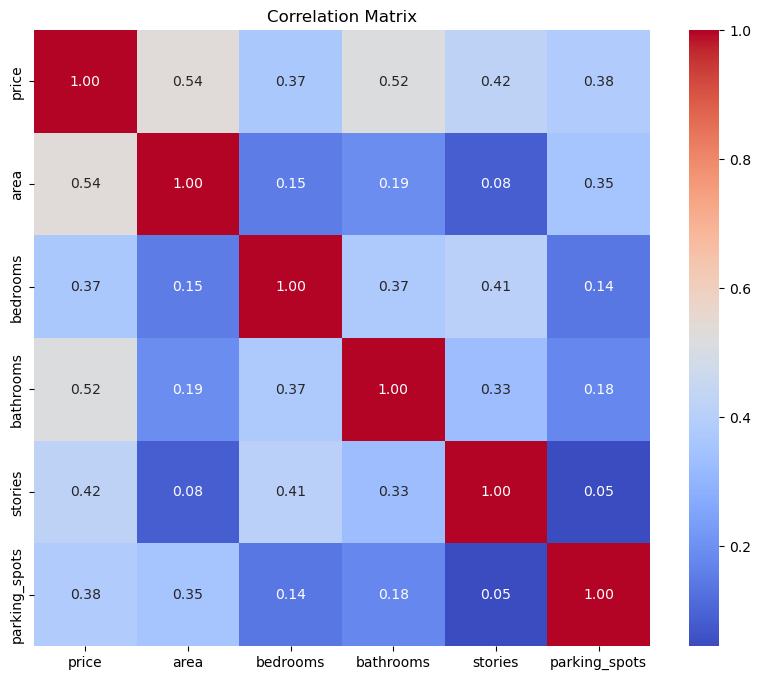

Variables price and area have high correlation (0.54)
Variables price and bathrooms have high correlation (0.52)

        Variable        VIF
0          price  17.110853
1           area   8.895295
2       bedrooms  13.766850
3      bathrooms  10.718360
4        stories   7.463489
5  parking_spots   2.017673


In [72]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Compute the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Visualize the correlation matrix
mp.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
mp.title('Correlation Matrix')
mp.show()

# Check for high correlation values
high_correlation_threshold = 0.5
high_correlation_pairs = np.where(np.abs(correlation_matrix) > high_correlation_threshold)

# Print pairs of variables with high correlation
for i, j in zip(*high_correlation_pairs):
    if i != j and i < j:
        print(f'Variables {numerical_columns[i]} and {numerical_columns[j]} have high correlation ({correlation_matrix.iloc[i, j]:.2f})')
print()

# Compute VIF
vif_data = df[numerical_columns]
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
print(vif)


&nbsp;

As we can observe from our variance inflation factor (VIF), our numerical data exhibits high levels of multicollinearity, indicated by values exceeding 10, which are considered significant and require correction. We will monitor this issue closely, as future preprocessing steps may help alleviate multicollinearity.

--- 

# Data Preprocessing 

---

## Removing Outliers

&nbsp;

In [73]:
# Function to detect and remove outliers 
def remove_outliers(df, columns, threshold=1.5):
    cleaned_df = df.copy() 
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        cleaned_df = cleaned_df[(cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound)]
        num_outliers = outliers.shape[0]
        num_rows = cleaned_df.shape[0]
        print(f"Number of outliers removed for {column}: {num_outliers}")
    
    return cleaned_df

df = remove_outliers(housing_data, ['area', 'price'])

print(df.shape)

Number of outliers removed for area: 12
Number of outliers removed for price: 15
(520, 13)


Using the standard cutoff value of ± 1.5 times the interquartile range (IQR), we have identified outliers in our 'price' and 'area' variables. By removing these outliers, a total of 25 rows have been eliminated from our dataset.

---

## Feature Engineering  

&nbsp;

In [74]:
# Categorical features 
categorical_cols = ['main_road', 'guest_room', 'air_conditioning', 'furnishing_status', 'basement', 'hot_water_heating', 'preferred_area']

# Numerical features 
numerical_cols = ['bedrooms', 'bathrooms', 'area', 'stories']

# Define preprocessing steps inside the pipeline 
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scaling numerical columns
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])


# Combine preprocessing steps for numerical and categorical columns using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Prepare features (X) and target variable (y) using the preprocessor pipeline
drop_columns = ['price']

train_X = preprocessor.fit_transform(train_df.drop(columns=drop_columns))
train_y = train_df['price']
val_X = preprocessor.transform(test_df.drop(columns=drop_columns))
val_y = test_df['price']

print("Training features shape:", train_X.shape)
print("Training target shape:", train_y.shape)
print("Testing features shape:", val_X.shape)
print("Testing target shape:", val_y.shape)



Training features shape: (416, 12)
Training target shape: (416,)
Testing features shape: (104, 12)
Testing target shape: (104,)


In [75]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols).tolist()
vif_data["VIF"] = [variance_inflation_factor(train_X, i) for i in range(train_X.shape[1])]

print(vif_data)


                             feature       VIF
0                           bedrooms  1.394451
1                          bathrooms  1.230351
2                               area  1.163420
3                            stories  1.482279
4                      main_road_yes  3.745540
5                     guest_room_yes  1.458872
6               air_conditioning_yes  1.635416
7   furnishing_status_semi-furnished  2.013240
8      furnishing_status_unfurnished  1.737913
9                       basement_yes  2.039401
10             hot_water_heating_yes  1.064106
11                preferred_area_yes  1.472794


&nbsp;

<b>Inference:</b> Multicollinearity concerns seem to have been mitigated after data processing, as indicated by acceptable variance inflation factor (VIF) values for the variables.

---

Let's now split our preprocessed data into training and testing sets, which is done after preprocessing to prevent data leakage.

In [77]:
# Function to organize display of training/testing set features/targets  
def print_section_header(header):
    print(f"{'=' * 30}")
    print(f"{header}")
    print(f"{'=' * 30}")

def print_columns(header, columns):
    print(f"{header}:")
    print(", ".join(columns))

def print_data(header, data):
    print(f"{header}:")
    print(data)

# Print training and testing data
print_section_header("Training Data")
print_columns("Training features (X) columns", train_df.drop(columns=drop_columns).columns)
print_data("Training target (y)", train_y)

print("\n") 

print_section_header("Testing Data")
print_columns("Testing features (X) columns", test_df.drop(columns=drop_columns).columns)
print_data("Testing target (y)", val_y)


Training Data
Training features (X) columns:
area, bedrooms, bathrooms, stories, main_road, guest_room, basement, hot_water_heating, air_conditioning, parking_spots, preferred_area, furnishing_status
Training target (y):
459    3115000
461    3080000
232    4655000
356    3773000
244    4550000
        ...   
90     6440000
126    5880000
294    4200000
460    3087000
121    5950000
Name: price, Length: 416, dtype: int64


Testing Data
Testing features (X) columns:
area, bedrooms, bathrooms, stories, main_road, guest_room, basement, hot_water_heating, air_conditioning, parking_spots, preferred_area, furnishing_status
Testing target (y):
299    4200000
112    6083000
21     8680000
189    5040000
109    6090000
        ...   
88     6475000
381    3605000
448    3150000
358    3745000
251    4515000
Name: price, Length: 104, dtype: int64


--- 

## Mutual Information Scores 

&nbsp;

In [78]:
# Calculate mutual information
mi_scores = mutual_info_regression(train_X, train_y)

# Create a dictionary to store feature names and their corresponding mutual information scores
mi_scores_dict = {feature: score for feature, score in zip(train_df.drop(columns=drop_columns).columns, mi_scores)}

# Sort the dictionary by mutual information scores in descending order
sorted_mi_scores = sorted(mi_scores_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature names and their corresponding mutual information scores
for feature, score in sorted_mi_scores:
    print(f"{feature}: {score}")


bathrooms: 0.2527041507329888
stories: 0.14217384172581626
bedrooms: 0.13246206363860646
basement: 0.12231030361491024
main_road: 0.08683700062971966
area: 0.08458672719897131
air_conditioning: 0.07979036326304434
guest_room: 0.07431693610482215
furnishing_status: 0.06254643903638435
hot_water_heating: 0.04713439763741056
parking_spots: 0.04612718714742714
preferred_area: 0.0


<b>Inference</b> Higher mutual information scores indicate stronger associations between specific features and the target variable 'price', suggesting they may offer more predictive potential. 


With our data split into testing and training sets, and a deeper understanding of its features and potential relationships, we're now ready to test our models and assess their predictive power by looking at the outcomes of various cost functions. 

--- 

# Model Testing


---

## Testing Set Metrics 

&nbsp;

We'll start by applying four regression algorithms—<b>Linear Regression, Decision Trees, Random Forest Regressor</b>, and <b>Gradient Boosting Regressor</b>—on both the training and testing sets of data. We'll then evaluate the cost functions of each model to get a better idea of which model is performing optimally in terms of predictive accuracy and generalization to unseen data. 

In [79]:
# Define models
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

# Train and evaluate each model
for model_name, model in models.items():
    
    model.fit(train_X, train_y)
    
    val_predictions = model.predict(val_X)
    
    # Cost functions 
    mae = round(mean_absolute_error(val_y, val_predictions), 4)
    mse = round(mean_squared_error(val_y, val_predictions), 4)
    rmse = round(mean_squared_error(val_y, val_predictions, squared=False), 4)
    r2 = round(r2_score(val_y, val_predictions), 4)
    n = len(val_y)
    k = val_X.shape[1]  
    adjusted_r2 = round(1 - ((1 - r2) * (n - 1) / (n - k - 1)), 4)
    
    print(f"{model_name} Metrics:")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  RMSE: {rmse}")
    print(f"  R-squared: {r2}")
    print(f"  Adjusted R-squared: {adjusted_r2}")
    print()

DecisionTree Metrics:
  MAE: 1020791.8269
  MSE: 1764566809997.1155
  RMSE: 1328369.9823
  R-squared: 0.4337
  Adjusted R-squared: 0.359

LinearRegression Metrics:
  MAE: 789372.7828
  MSE: 1091541479629.176
  RMSE: 1044768.6249
  R-squared: 0.6497
  Adjusted R-squared: 0.6035

RandomForest Metrics:
  MAE: 829213.9458
  MSE: 1239711803833.4385
  RMSE: 1113423.4611
  R-squared: 0.6021
  Adjusted R-squared: 0.5496

GradientBoosting Metrics:
  MAE: 831751.1755
  MSE: 1253331069668.094
  RMSE: 1119522.6973
  R-squared: 0.5978
  Adjusted R-squared: 0.5448



--- 

## Training Set Metrics

&nbsp;

In [80]:
# Define models
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

# Train and evaluate each model on the training set
for model_name, model in models.items():
    model.fit(train_X, train_y)
    
    train_predictions = model.predict(train_X)
    
    # Cost functions 
    mae = round(mean_absolute_error(train_y, train_predictions), 4)
    mse = round(mean_squared_error(train_y, train_predictions), 4)
    rmse = round(mean_squared_error(train_y, train_predictions, squared=False), 4)
    r2 = round(r2_score(train_y, train_predictions), 4)
    n = len(val_y)
    k = val_X.shape[1]  
    adjusted_r2 = round(1 - ((1 - r2) * (n - 1) / (n - k - 1)), 4)
    
    print(f"{model_name} Metrics on Training Set:")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  RMSE: {rmse}")
    print(f"  R-squared: {r2}")
    print(f"  Adjusted R-squared: {adjusted_r2}")
    print()

DecisionTree Metrics on Training Set:
  MAE: 8884.6154
  MSE: 4848408653.8462
  RMSE: 69630.5152
  R-squared: 0.998
  Adjusted R-squared: 0.9977

LinearRegression Metrics on Training Set:
  MAE: 679729.8775
  MSE: 825124879926.31
  RMSE: 908363.8478
  R-squared: 0.6534
  Adjusted R-squared: 0.6077

RandomForest Metrics on Training Set:
  MAE: 266393.7601
  MSE: 134506682940.8854
  RMSE: 366751.5275
  R-squared: 0.9435
  Adjusted R-squared: 0.936

GradientBoosting Metrics on Training Set:
  MAE: 469137.112
  MSE: 399167351845.9046
  RMSE: 631796.9229
  R-squared: 0.8323
  Adjusted R-squared: 0.8102



---

# Model Evalutions 

---

Let's assess the performance of our models by comparing their cost functions using tables. 

In [81]:
# Headers for the table columns
headers = ["Model", "MAE", "MSE", "RMSE", "R-squared", "Adjusted R-squared"]

# Cost function metrics from models 
def calculate_metrics(model, X, y):
    predictions = model.predict(X)
    mae = np.round(mean_absolute_error(y, predictions), 4)
    mse = np.round(mean_squared_error(y, predictions), 4)
    rmse = np.round(mean_squared_error(y, predictions, squared=False), 4)
    r2 = np.round(r2_score(y, predictions), 4)
    n = len(y)
    k = X.shape[1]
    adjusted_r2 = np.round(1 - ((1 - r2) * (n - 1) / (n - k - 1)), 4)
    return [mae, mse, rmse, r2, adjusted_r2]

# Define table data for testing set
testing_table_data = []
for model_name, model in models.items():
    model.fit(train_X, train_y)
    test_metrics = calculate_metrics(model, val_X, val_y)
    testing_table_data.append([model_name] + test_metrics)

# Define table data for training set
training_table_data = []
for model_name, model in models.items():
    model.fit(train_X, train_y)
    train_metrics = calculate_metrics(model, train_X, train_y)
    training_table_data.append([model_name] + train_metrics)

# Print testing set metrics
print(f"{' ':>38}Testing Set Metrics")
print(tabulate(testing_table_data, headers=headers, tablefmt="fancy_grid", numalign="center", stralign="center"))

print("\n", "---" * 36)

# Print training set metrics
print(f"{' ':>38}Training Set Metrics")
print(tabulate(training_table_data, headers=headers, tablefmt="fancy_grid", numalign="center", stralign="center"))


                                      Testing Set Metrics
╒══════════════════╤═════════════╤═════════════╤═════════════╤═════════════╤══════════════════════╕
│      Model       │     MAE     │     MSE     │    RMSE     │  R-squared  │  Adjusted R-squared  │
╞══════════════════╪═════════════╪═════════════╪═════════════╪═════════════╪══════════════════════╡
│   DecisionTree   │ 1.01702e+06 │ 1.76939e+12 │ 1.33019e+06 │   0.4321    │        0.3572        │
├──────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼──────────────────────┤
│ LinearRegression │   789373    │ 1.09154e+12 │ 1.04477e+06 │   0.6497    │        0.6035        │
├──────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼──────────────────────┤
│   RandomForest   │   836099    │ 1.23561e+12 │ 1.11158e+06 │   0.6035    │        0.5512        │
├──────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼──────────────────────┤
│ GradientBoosting │   832631    │ 1.25535

Upon reviewing our tables, it's evident that the <b>linear regression</b> model had the best performance on the testing set. With the lowest MAE, MSE, and RMSE scores, alongside the highest R-squared and Adjusted R-squared values, the model had the best fit of the data. 

From the training set, it's clear that the decision tree, random forest, and to a lesser extent, the gradient boosting model, all performed significantly better. This indicates possible overfitting to the training data. Conversely, the linear regression model showed only a slight advantage on the training set, suggesting that it hasn't overgeneralized to the data. 

---

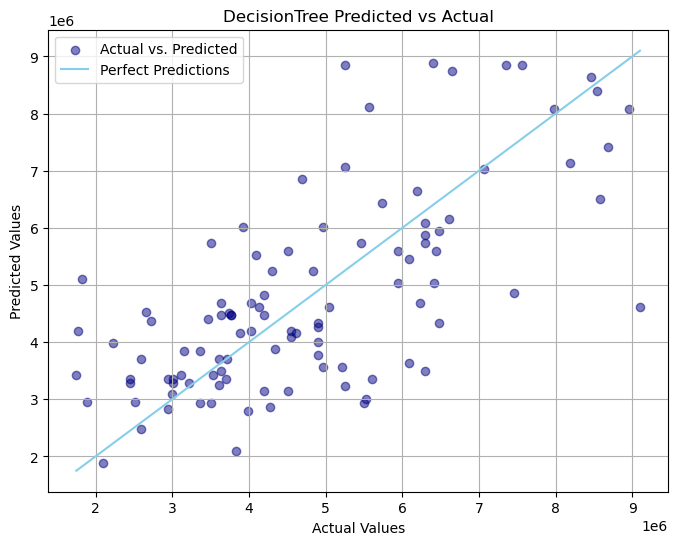

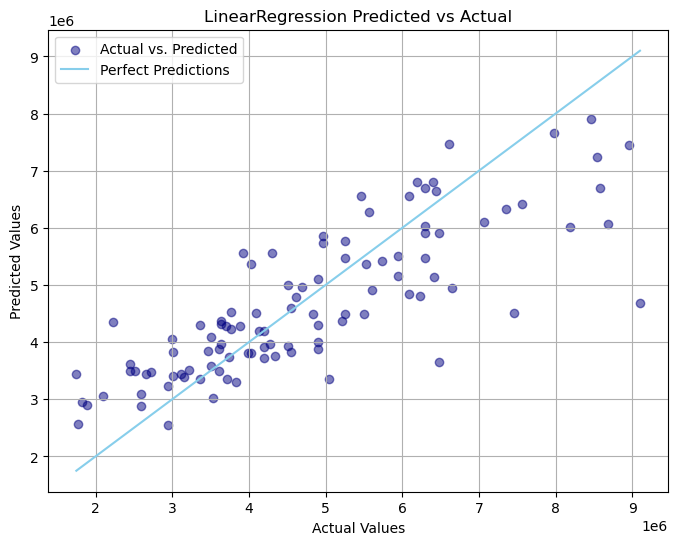

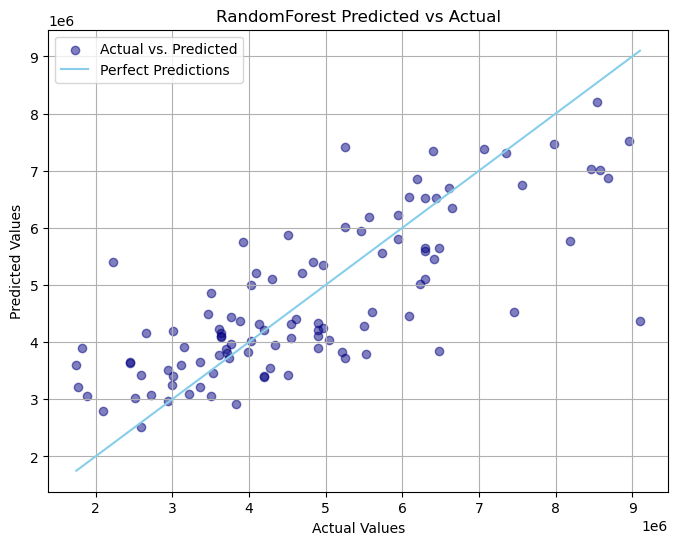

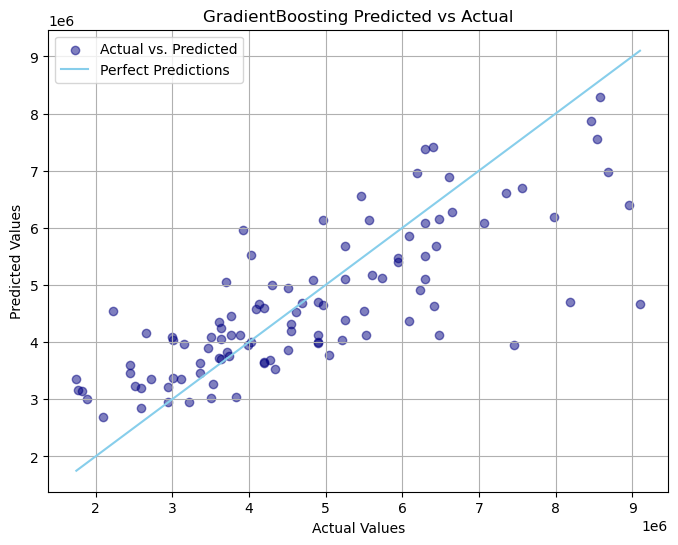

In [82]:
def plot_predictions(model_name, actual, predicted):
    mp.figure(figsize=(8, 6))
    
    # Actual vs. Predicted scatter plot
    mp.scatter(actual, predicted, color='navy', alpha=0.5, label='Actual vs. Predicted')
    
    # Diagonal line representing perfect predictions
    mp.plot([min(actual), max(actual)], [min(actual), max(actual)], color='skyblue', label='Perfect Predictions')
    
    # Labels and title
    mp.title(f'{model_name} Predicted vs Actual')
    mp.xlabel('Actual Values')
    mp.ylabel('Predicted Values')
    
    mp.legend()
    
    mp.grid(True)
    
    mp.show()

# Plot predicted vs actual values for each model
for model_name, model in models.items():
    # Make predictions on validation data
    val_predictions = model.predict(val_X)
    
    # Plot predicted vs actual values
    plot_predictions(model_name, val_y, val_predictions)





&nbsp;

 In examining the graphs, we can readily observe the disparity between the predicted values generated by our models and the actual values. The 'perfect predictions line' serves as a reference, indicating when our model's predictions precisely match the actual target values. When the predicted values exceed this line, it signifies that our model has overestimated the price, whereas falling below the line indicates an underestimation. Notably, the <b>decision tree</b> model displays the highest variance around the actual values, suggesting the greatest fluctuations in prediction accuracy. Conversely, the other models demonstrate relatively comparable performance. 

---

Lastly, we can visualize the <b>RMSE</b> cost function among the various models' performance on both the training and testing sets. Ideally, we want to observe minimal differences between both sets, as significant disparities in performance may indicate an overfitting or underfitting of the data.

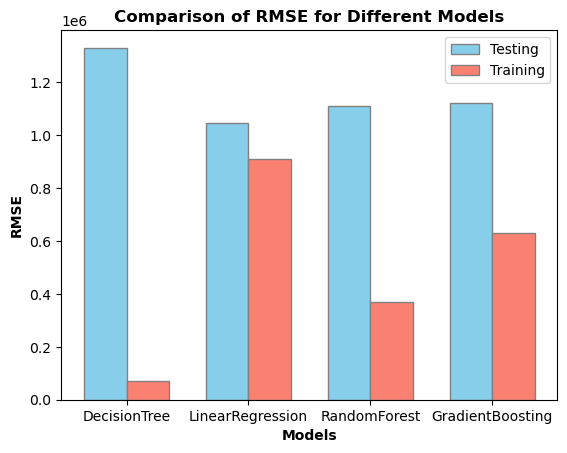

In [83]:
# Extract RMSE for testing and training sets for each model
testing_rmse = [row[3] for row in testing_table_data]
training_rmse = [row[3] for row in training_table_data]

# Define model names
model_names = list(models.keys())

# Set width of bar
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]

# Create side-by-side bar plot
mp.bar(r1, testing_rmse, color='skyblue', width=bar_width, edgecolor='grey', label='Testing')
mp.bar(r2, training_rmse, color='salmon', width=bar_width, edgecolor='grey', label='Training')

# Add xticks on the middle of the group bars
mp.xlabel('Models', fontweight='bold')
mp.ylabel('RMSE', fontweight='bold')
mp.xticks([r + bar_width / 2 for r in range(len(model_names))], model_names)
mp.title('Comparison of RMSE for Different Models', fontweight='bold')

mp.legend()

mp.show()

From our barplot, it's evident that the <b>linear regression</b> model strikes the best balance in generalizing to the data, as the disparities between sets are relatively small. Conversely, the other models seem to have overgeneralized the data, particularly noticeable in the wide range of values between sets for the <b>decision tree</b> model.

---

# Conclusions 

---

In conclusion, our analysis of predictive regression modeling for housing prices has provided us with valuable insights into the performance of various machine learning algorithms. The <b>linear regression</b> model emerged as the most promising candidate, demonstrating a balanced generalization to the data with minimal disparities between the training and testing sets. This suggests its effectiveness in accurately predicting housing prices in our dataset while mitigating the risks of overfitting or underfitting. Conversely, the <b>decision tree</b> model exhibited significant overfitting, as evidenced by the wide range of values between sets. These results highlight the importance of careful model selection and evaluation in real estate valuation tasks. Moving forward, further refinement and optimization of the linear regression model could potentially lead to enhanced predictive capabilities, offering valuable contributions to more accurate housing price predictions in the future.

--- 

###### Feel free to connect with me on [LinkedIn](https://www.linkedin.com/in/nluc22/) to stay updated on my latest projects and insights. I look forward to hearing from you!

&nbsp;